# WALLABY CADC ADQL Access Tutorial Notebook

This notebook is designed to help a user access the WALLABY survey database stored on CADC through ADQL.  It focuses on TAP (Table Access Protocal) usage.


The first step in using this notebook is to import the required python modules

In [1]:
#Importing all required modules  
#     numpy is used in this notebook for some very basic sample analysis
import numpy as np
#     The pyvo module contains the basic TAP service
from pyvo.dal import TAPService
#     The astropy table module provides the user with access to the power astropy Table class
from astropy.table import Table
#     The astroquery module does the querying of the tables
from astroquery.utils.tap.core import Tap, TapPlus

from astroquery.cadc import Cadc

import requests

Next we need to specify the catalogue service to use at CADC.  The WALLABY database is accessed through their 'youcat' service.  The technical details for youcat can be found at:
https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/youcat/

A very good resource for further queries and tests is:
https://astroquery.readthedocs.io/en/latest/cadc/cadc.html

In [2]:
#Set up the youcat url
yc_url = 'https://ws-cadc.canfar.net/youcat' 

Before we go through the full data access exercise, it is helpful to set up a few python VO functions using the pyvo TAPService module

In [3]:
####pyvo queries, see https://pyvo.readthedocs.io/en/stable/dal/index.html

#     This function goes through a particular client and prints out all the publically accessable tables/databases
def pyvo_tables(tap_url=yc_url):
    'print available tables in TAP client'
    ###set up tap client
    client = TAPService(tap_url)

    ###print available tables
    tables = list(client.tables.keys())
    for table in tables:
       print(table)
    return

#     This function runs an ADQL query of a public YouCAT database.
def pyvo_query(query, tap_url=yc_url, upload_data={}):
    'ADQL query of public CADC YouCat database'

    ###set up tap client
    client = TAPService(tap_url)

    ###query data
    data = client.search(query).to_table()

    return(data)

It is good practice to log-in to CADC (although not strictly necessary for public data).  The easiest way to log-in is with an up-to-date CADC certificate. To get this file, see the Query CADC metadata using TAP section of this page https://astroquery.readthedocs.io/en/latest/cadc/cadc.html .  In short, log-in to the web portal, click on your name in the right hand side, and then click on Obtain a Certificate.  Place this certificate in the same directory as this notebook and then log-in.

In [4]:
#Log into CADC using a 'certificate'
Cadc().login(certificate_file='cadcproxy.pem')

There are two tables that host the WALLABY pilot data release I (PDR1) catalogues; one for the sources and one for the kinematic models.

In [5]:
#Set the source table name
SRCTABLE="cirada.Wallaby_dr1_source_catalogue"
#Set the kinematic table name
KINTABLE="cirada.Wallaby_dr1_kinematic_catalogue"

Working with the source catalogue first, we can run a few tests.  The first, and simplest is to simply query the first 10 objects in the table

In [6]:
#First define the basic query
SRC_top10query="SELECT TOP 10 * FROM %s" % SRCTABLE
#Now query the table using a basic ADQL command
SRC_Top10=pyvo_query(SRC_top10query)
#And print off the data
print(SRC_Top10)

         name                 ra               dec              freq       ... team_release       dist_h            log_m_hi    
                             deg               deg               Hz        ...                     Mpc                Msol      
---------------------- ---------------- ----------------- ---------------- ... ------------ ------------------ -----------------
WALLABY J100321-291708 150.838754090075 -29.2856143600128 1350554882.04651 ...    Hydra TR2 221.50434193083527 9.944488440184053
WALLABY J100336-262923 150.903417524457 -26.4899525051286 1416150566.26878 ...    Hydra TR2 12.868612686918116  7.89593142190572
WALLABY J100342-270137 150.925581251107 -27.0271233410342 1415884402.68313 ...    Hydra TR2 13.676120058758036 9.318490798472174
WALLABY J100351-263707 150.964352979355 -26.6186126212923  1416277943.1486 ...    Hydra TR2 12.482274382348654 8.509986427631143
WALLABY J100351-273417 150.966205246492 -27.5715028775967  1407297955.2379 ...    Hydra TR2  39.8

There are 4 different source releases in the WALLABY PDR1; Hydra TR1, Hydra TR2, Norma TR1, and NGC 4636 TR1.  To grab all the entries for a specific field we can use a query like:

In [7]:
#Set the name of the target release
TargSRCTR="Hydra TR2"
#Use the team_release column
ColUse="team_release"
#Write the query to select only those objects with this name
FieldQuery="SELECT * FROM " +SRCTABLE  + " where "+ColUse+"='"+TargSRCTR+"'"
#Query the database
HydraFieldSrcs=pyvo_query(FieldQuery)

It is possible to simply save the table for use on your local machine.  

In [8]:
#In order to save the file as a fits file, the filename must be specified
fitsname="HydraTR2_SRC.fits"
#Then we can use built-in astropy write function to write the table as a fits file.  See 
HydraFieldSrcs.write(fitsname,format='fits',overwrite=True)
#It is also possible to save the table using tab separated values
#    Again, set the name
tsvname="HydraTR2_SRC.tsv"
#    And use the tsv output for ease in writing
HydraFieldSrcs.write(tsvname,format='ascii.tab',overwrite=True)

It is possible to use the downloaded table to do some science.  We'll start by calculating some physically meaningful parameters such as redshift or HI mass from the SoFiA measurements.  These are straightforward to add to the Astropy Table via table["ParamName"]=<expression>

In [9]:
#Start with importing some useful modules
import scipy.constants as const
from astropy.cosmology import FlatLambdaCDM

# For some ease in notation, we'll rename our Hydra field source table to table
table=HydraFieldSrcs

# Set up cosmology
f_rest = 1.42040575e+9;  # HI rest frequency in Hz
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

# Calculate redshift
table["redshift"] = f_rest / table["freq"] - 1.0

# Calculate luminosity distance in Mpc and HI mass in solar masses
table["dl"] = cosmo.luminosity_distance(table["redshift"]).value
table["log_mhi"] = np.log10(49.7 * table["dl"] * table["dl"] * table["f_sum"])

# Calculate source rest frame velocity width in km/s
table["dv"] = const.c * (1.0 + table["redshift"]) * table["w20"] / f_rest / 1000.0

# Show our new parameters
table["name", "redshift", "dl", "log_mhi", "dv"].pprint(max_width=-1)

         name                 redshift               dl              log_mhi               dv        
---------------------- --------------------- ------------------ ------------------ ------------------
WALLABY J100321-291708   0.05172012546994331  230.2200387218069  9.978010198063501 105.23725227105899
WALLABY J100336-262923 0.0030047537547024383 12.898539152412877  7.897949014653588 112.66574679432964
WALLABY J100342-270137 0.0031933025805650495 13.709918580794236  9.320634740392718  197.8573912211532
WALLABY J100351-263707 0.0029145457439117006 12.510431512913494  8.511943557308177  153.6281920983406
WALLABY J100351-273417   0.00931415746986164  40.17716958107245   9.76846902185776  339.4093374768185
WALLABY J100426-282638 0.0036128702681572644 15.516281961854776  9.285731439549677 212.27321822473257
WALLABY J100539-282633 0.0034754334646216467 14.924447526818899  8.809184514698632 104.77400632561434
                   ...                   ...                ...                ...

Now we can make a basic plot showing the logarithmic HI mass against redshift and additionally colour the data points by source rest frame velocity width.

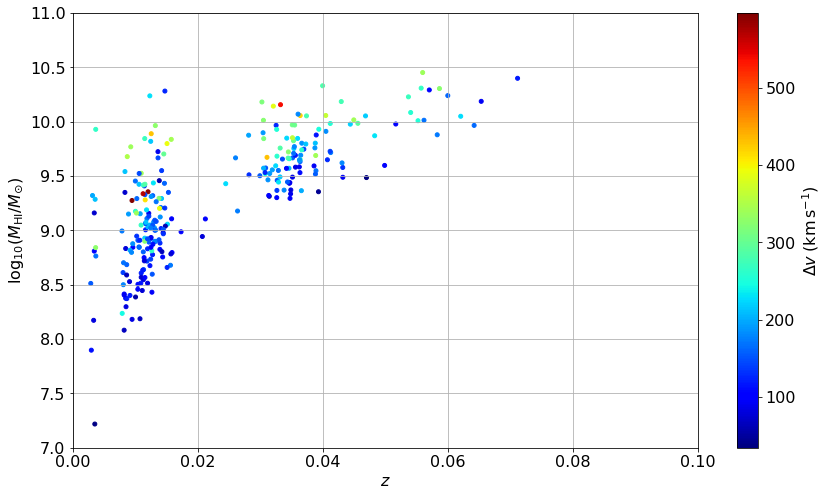

In [10]:
#As usual, we'll import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#To make the plot look a bit nicer, we'll set the figure size and font size
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["font.size"] = 16

#Now we'll make the scatter plot of redshift and mass colored by velocity width
plt.scatter(HydraFieldSrcs["redshift"], HydraFieldSrcs["log_mhi"], s=16, c=HydraFieldSrcs["dv"], cmap="jet")

#Finally, we'll make the plot look more attractive via labels, a colorbar, and reasonable limits
plt.xlabel(r"$z$")
plt.ylabel(r"$\log_{10}(M_{\rm HI} / M_{\odot})$")
cbar = plt.colorbar()
cbar.set_label(r"$\Delta v \; (\mathrm{km \, s}^{-1})$")
plt.xlim(0.0, 0.1)
plt.ylim(7.0, 11.0)
plt.grid(True)
#And show the plot here
plt.show()

There are more advanced queries that can be made of the table.  For instance, we can query based on a specific position. For this example, we've set a search centered on WALLABY J100321-291708 that is 5 degrees in size

In [11]:
####query based on a single position 
posquery = "SELECT * FROM %s \
WHERE 1=CONTAINS(POINT('ICRS', 150.838754090075, -29.2856143600128), CIRCLE('ICRS', ra, dec, 5.0))" % SRCTABLE

PositionSrcs=pyvo_query(posquery)
print("Number of sources in 5 degrees around WALLABY J100321-291708= ",len(PositionSrcs))

Number of sources in 5 degrees around WALLABY J100321-291708=  95


To download the data, we will use the wget package for simplicity.  The download can take some time, so check that this is working.

In [12]:
#For downloading, we'll use wget.  It is possible to use other tools like curl or the request package
import wget
import os


cadc=Cadc()

#re-login into CADC using a 'certificate'
cadc.login(certificate_file='cadcproxy.pem')

#  Set the a dictionary of query parameters to use
collection='WALLABY'              #Selecting WALLABY makes sure we only get WALLABY products
instrument_name='ASKAP'           #
prodID='source_data_Hydra_TR2'    #The product ID can be used to select only the source or kinematic data products
query_params = {
    'instrument_name': instrument_name,
    'collection': collection,
    'prodID':prodID
}
#  Set a name for the target folder
Foldername="HydraTR2_Top10"
#  To make life easiser, we'll make this folder now
os.makedirs(Foldername, exist_ok=True)
#  We'll also define a folder for the product (to keep the sources separate from kinematic models in the future)
ProdFolder="Source/"

#   For this test, we'll try to get the first 10 sources from Hydra TR2.  As such, we'll use the SRC_Top10 query of object properites
#   Loop through each name in the table
for i in range(len(SRC_Top10)):
    #    Select the galaxy name from the source tableand add it to the query_params dictionary
    x=SRC_Top10['name'][i]
    query_params['target_name']=x
    #  Set the query 
    query = '''SELECT * FROM caom2.Plane AS Plane 
    JOIN caom2.Observation AS Observation ON Plane.obsID = Observation.obsID 
    WHERE  ( Observation.instrument_name = '{instrument_name}'
    AND Observation.collection = '{collection}'
    AND Observation.target_name = '{target_name}'
    AND Plane.productID ='{prodID}'
    AND ( Plane.quality_flag IS NULL OR Plane.quality_flag != 'junk' ) )
    '''.format(**query_params)

    #  Run the query
    TargResults=cadc.exec_sync(query)
    #   Get the galaxy name
    GName=TargResults['observationID'][0]

    # Before getting the file urls, let's make a folder for the galaxy
    GalaxyFolder=Foldername+"/"+GName+"/"
    DestinationFolder=GalaxyFolder+ProdFolder  
    os.makedirs(DestinationFolder, exist_ok=True)
    
    #  Now we'll get the full list of urls associated with this galaxy and product
    urls=cadc.get_data_urls(TargResults) #The include auxiliaries gets the 'preview' images
    # We can now loop through the urls to get each file
    for url in urls:
        # Figure out the file name
        FName=url.split("/")[-1]
        #  Name the output file
        FileDest=DestinationFolder+FName
        #  And run wget for the files
        wget.download(url, FileDest)




100% [..............................................................................] 11520 / 11520

# Kinematic Table

Now that we've down work with the PDR1 source table, we can move to the kinematic table.  Let's start by getting all the kinematic models for Hydra Kin TR2.

In [13]:
#Set the name of the target release
TargKinTR="Hydra Kin TR2"
#Use the team_release column
ColUse="team_release_kin"
#Write the query to select only those objects with this name
FieldQuery="SELECT * FROM " +KINTABLE  + " where "+ColUse+"='"+TargKinTR+"'"
#Query the database
HydraFieldKin=pyvo_query(FieldQuery)

In addition to all the operations from earlier, we can also do some science with this catalogue.  As an example, we'll make a plot showing all the rotation curves in this field.  

In [14]:
#This function parses one of the vector entries from the kinematic catalogue
def ParseColEntry(Entry):
    #Split the vector by the comma's
    Vals=Entry.split(',')
    #Loop through all the values
    for i in range(len(Vals)):
        #Convert from a string to a float
        Vals[i]=float(Vals[i])
    #Return the column as a numpy array
    return np.array(Vals)

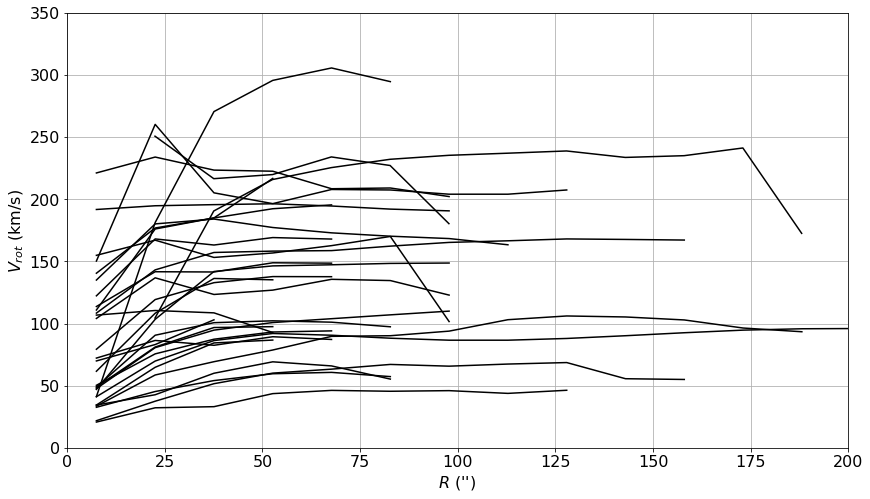

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
#To make the plot look a bit nicer, we'll set the figure size and font size
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["font.size"] = 16

#The radius and velocity columns must be converted from strings to vectors.  To do this, we loop through each row
for i in range(len(HydraFieldKin)): 
    #  Then we can use the ParseColEntry we made earlier to get the arrays
    R=ParseColEntry(HydraFieldKin['Rad'][i])
    V=ParseColEntry(HydraFieldKin['Vrot_model'][i])
    
    #Then we can plot the rotation curve for this particular galaxy.
    plt.plot(R, V, ls='-',color='k',marker='')
    
#Finally, we'll make the plot look more attractive via labels, a colorbar, and reasonable limits
plt.xlabel(r"$R$ ('') ")
plt.ylabel(r"$V_{rot}$ (km/s)")
#cbar = plt.colorbar()
#cbar.set_label(r"$\Delta v \; (\mathrm{km \, s}^{-1})$")
plt.xlim(0.0, 200)
plt.ylim(0, 350)
plt.grid(True)
    
plt.show()

When we are finished, we can log out from CADC

In [16]:
Cadc.logout()